# Анализ данных о продаже автомобилей

Данные будут загружатся со следующего источника http://klaksona.net/

In [303]:
eur = 1.11

курс евро к доллару

In [304]:
pmr = 16.5

курс пмр к доллару

# Импорт библиотек и функций

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import phik
import time
import shap
import tqdm
import sys

import requests
from bs4 import BeautifulSoup as bs
import re
from tqdm.notebook import trange, tqdm
from tqdm.gui import tqdm as tqdm_gui
from IPython.display import display

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from catboost import CatBoostClassifier

In [199]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_seq_items', 1000)
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True 
tqdm.pandas() 

In [645]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Загрузка функций

In [4]:
def preprocessing(x):
    print(f'таблица имеет следующий вид:')
    display(x.head())
    print('*'*100)
    print(f'таблица имеет {x.shape[0]} сторок и {x.shape[1]} столбцов')
    print('*'*100)
    print(f'в таблице обнаружено дублекатов:{x.duplicated().sum()}')
    print('*'*100)
    print('в таблице обнаружены пропуски в следующих столбцах:')
    display(x.isna().sum())
    print('*'*100)
    print('Эти пропуски составлябт следующее количество в процентах')
    display((x.isna().mean()* 100).round(1))
    print('*'*100)
    print('столбцы имеют следующие типы:')
    display(x.dtypes)
    x.columns = [y.lower().replace(' ', '_') for y in x.columns.values] 
    print('*'*100)
    print('названия столбцов переписаны в нижнем регистре, пробелы заменены на нижнее подчеркивание')
    print('*'*100)
    display(x.info())

Функция предпроцессинга, котораяпоказывет информацию о данных и заменяет названия столбцов

In [5]:
j=1
def parsing_2(url):
    data = pd.DataFrame(columns=['id', 'title', 'url', 'date_parsing', 'brend',  'volume', 'тип_двигателя', 'год', 'prise']) 
    reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=1')
    soup = bs(reqx.text, 'html.parser')
    element = soup.findAll('a', class_="ajax_link")
    max_page = int(element[-8].text)
    for j in tqdm(range(1,max_page)):        
        reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=' + str(j))
        soup = bs(reqx.text, 'html.parser')
        element = soup.findAll('div', class_='border_type_0')
        datax = []
        for i in element:
            datax.append({'id'  : i.find('a')['href'].split('/')[-1].replace('.html',''),
                          'title' : i.find('h1').text.lstrip(' ').rstrip(' '),
                          'url' : i.find('a')['href'],
                          'brend' : i.find('h1').text.split(' ')[2],
                          'date_parsing' : pd.to_datetime('today').normalize(),
                          'volume'  : i.find('tr').text.split('\r\n')[3].replace(' ',''),
                          'тип_двигателя' : i.find('tr').text.split('\r\n')[7].replace(' ',''),
                          'год' : i.find('td').text.lstrip(' ').rstrip(' ').split(' ')[1].replace('г.',''),
                          'prise' : (str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[3]) + 
                                     str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[4]) + 
                                     str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[5]))
                         })
        datax = pd.DataFrame(datax)
        data = pd.concat([data, datax] , ignore_index=True)
    return data

Функция парсинга, которая создает датафрейм, в который добавляет информацию об инентификаторе, названии, ссылки, бренде, дате парсинга, объеме двигателя, годе выпуска двигателя и цене автомобиля

reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=1' )
soup = bs(reqx.text, 'html.parser')
element = soup.findAll('div', class_='border_type_0')
element

element[2].find('tr').text.lstrip(' ').rstrip(' ').split(' ')[3]

element[2].find('tr').text.lstrip(' ').rstrip(' ').split(' ')[4]

element[2].find('tr').text.lstrip(' ').rstrip(' ').split(' ')[5]

In [6]:
def add_details(x):
    reqx = requests.get(x)
    soup = bs(reqx.text, 'html.parser')
    element = soup.findAll('div', class_='container')
    lists = element[0].text.split('\n')
    if lists.count('Дополнительная информация:'):
        dop_info = lists.pop(lists.index('Дополнительная информация:') + 1).strip()
    else:
        dop_info = np.NaN
    if lists.count('Класс автомобиля:'):
        class_auto = lists.pop(lists.index('Класс автомобиля:') + 1).replace(' ','')
    else:
        class_auto = np.NaN
    if lists.count('Тип кузова:'):
        body = lists.pop(lists.index('Тип кузова:') + 1).replace(' ','')
    else:
        body = np.NaN
    if lists.count('Состояние:'):
        state = lists.pop(lists.index('Состояние:') + 1).replace(' ','')
    else:
        state = np.NaN  
    if lists.count('Кол-во дверей:'):
        door = lists.pop(lists.index('Кол-во дверей:') + 1).replace(' ','')
    else:
        door = np.NaN
    if lists.count('Потребляемое топливо:'):
        fuel = lists.pop(lists.index('Потребляемое топливо:') + 1).replace(' ','')
    else:
        fuel = np.NaN
    if lists.count('Коробка передач:'):
        transmission = lists.pop(lists.index('Коробка передач:') + 1).replace(' ','')
    else:
        transmission = np.NaN
    if lists.count('Кондиционер:'):
        conditioner = lists.pop(lists.index('Кондиционер:') + 1).replace(' ','')
    else:
        conditioner = np.NaN
    if lists.count('Аудиосистема:'):
        audio = lists.pop(lists.index('Аудиосистема:') + 1).replace(' ','')
    else:
        audio = np.NaN
    if lists.count('Пробег'):
        mileage = lists.pop(lists.index('Пробег') + 1).replace(' ','')
    else:
        mileage = np.NaN
    if lists.count('Контактное лицо'):
        contact = lists.pop(lists.index('Контактное лицо') + 1).replace(' ','')
    else:
        contact = np.NaN
    if lists.count('Телефон'):
        fone = lists.pop(lists.index('Телефон') + 1).replace(' ','')
    else:
        fone = np.NaN
    if lists.count('Размещено:'):
        date_notice = lists.pop(lists.index('Размещено:') + 1).replace(' ','')
    else:
        date_notice = np.NaN
    
    return pd.Series([dop_info, class_auto, body, state, door, fuel, transmission, conditioner, audio, mileage, contact, fone, date_notice])

Функция которая добовляет в датафрейм дополнительную информацию а также информацию о классе автомобиля, типе кузова, состоянии автомобиля, количестве дверей, потребляемом топриве и типе коробки передачь, наличии и типе климатической системы аудиосистемы, а также информацию о контактном лице его телефоне и дате размещения объявления

In [18]:
def rename_date(x):
    x = str(x)
    dat = x[:-5] + ' ' + x[-5:]
    dat = dat.replace('сегодняв', str((df.loc[0, 'date_parsing']).strftime('%d.%m.%Y')))
    dat = dat.replace('вчерав', str((df.loc[0, 'date_parsing'] - pd.Timedelta(days=1)).strftime('%d.%m.%Y')))
    return dat

Функция преобразования даты загрузки объявления

In [60]:
def model_name(x):
    x = str(x)
    x = x.split()
    return " ".join(x[1:])            

Функция которая вырезает модель автомобиля из его названия

In [305]:
def norm_price(x):
    if 'руб' in x:
        return round(int(x[:-4])/pmr)
    elif '$' in x:
        return round(int(x[:-1]))
    elif '€' in x:
        return round(int(x[:-1])*eur)
    else:
        return np.nan

# Загрузка данных

In [7]:
oll_url=['http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=']

In [8]:
df = parsing_2(oll_url)

  0%|          | 0/859 [00:00<?, ?it/s]

In [9]:
df[['dop_info', 'class_auto', 'body', 'state', 'door', 'fuel',
   'transmission', 'conditioner', 'audio', 'mileage', 'contact',
   'fone', 'date_notice']] = df['url'].progress_apply(add_details)

  0%|          | 0/10280 [00:00<?, ?it/s]

In [10]:
df.head()

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
0,auto1691409,Lexus RX 400h,http://klaksona.net/avtorynok-pmr/auto1691409.html,2024-10-01,Lexus,3300,Гибрид,2009,10800$,NaN,Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитола,168000,Тирасполь,77904221,сегодняв14:57
1,auto1691408,Комплектующие кузовные детали,http://klaksona.net/avtorynok-pmr/auto1691408.html,2024-10-01,,неуказано,неуказано,2006,договорная\n\n\n\n\n\n\n,"Передняя и задняя дверь Тойота Камри 40 под реставрацию, левая сторона, был удар по касательной.",Легковой,седан,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,077799460,сегодняв14:55
2,auto1691407,Opel Rekord,http://klaksona.net/avtorynok-pmr/auto1691407.html,2024-10-01,Opel,2,Бензин-Газ,1983,650$,Опель рекорд.2.0 бензин газ пропан.650у.е торг.77779008. бендеры,NaN,NaN,NaN,NaN,газ,NaN,NaN,NaN,NaN,Авто,077779008,сегодняв14:55
3,auto1691406,Комплектующие диски и шины,http://klaksona.net/avtorynok-pmr/auto1691406.html,2024-10-01,,неуказано,неуказано,2017,40$,"Продам пару шин Yоcohama 235/55/R18,стояли на машине без шишек порезов причина продажи, перешли на размер больше. Цена за пару,",Легковой,внедорожник,Удовлетворительное,NaN,NaN,NaN,NaN,NaN,NaN,Павел(Всеобъявленияэтогопользователя),77737529,сегодняв14:55
4,auto1691405,Комплектующие кузовные детали,http://klaksona.net/avtorynok-pmr/auto1691405.html,2024-10-01,,неуказано,неуказано,2006,договорная\n\n\n\n\n\n\n,"Продам заднюю крышку багажника Тойота Авенсис т25 универсал, задний бампер, имеется крышка багажника на разбор.",Легковой,универсал,Хорошее,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,077799460,сегодняв14:53


In [11]:
df.to_csv('csv/klakson.csv', index=False) 

In [578]:
df = pd.read_csv('csv/klakson.csv')

# Предобработка данных

In [579]:
preprocessing(df)

таблица имеет следующий вид:


,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
0,auto1691409,Lexus RX 400h,http://klaksona.net/avtorynok-pmr/auto1691409.html,2024-10-01,Lexus,3300,Гибрид,2009,10800$,NaN,Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитола,168000.0,Тирасполь,77904221,сегодняв14:57
1,auto1691408,Комплектующие кузовные детали,http://klaksona.net/avtorynok-pmr/auto1691408.html,2024-10-01,NaN,неуказано,неуказано,2006,договорная\n\n\n\n\n\n\n,"Передняя и задняя дверь Тойота Камри 40 под реставрацию, левая сторона, был удар по касательной.",Легковой,седан,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,077799460,сегодняв14:55
2,auto1691407,Opel Rekord,http://klaksona.net/avtorynok-pmr/auto1691407.html,2024-10-01,Opel,2,Бензин-Газ,1983,650$,Опель рекорд.2.0 бензин газ пропан.650у.е торг.77779008. бендеры,NaN,NaN,NaN,NaN,газ,NaN,NaN,NaN,NaN,Авто,077779008,сегодняв14:55
3,auto1691406,Комплектующие диски и шины,http://klaksona.net/avtorynok-pmr/auto1691406.html,2024-10-01,NaN,неуказано,неуказано,2017,40$,"Продам пару шин Yоcohama 235/55/R18,стояли на машине без шишек порезов причина продажи, перешли на размер больше. Цена за пару,",Легковой,внедорожник,Удовлетворительное,NaN,NaN,NaN,NaN,NaN,NaN,Павел(Всеобъявленияэтогопользователя),77737529,сегодняв14:55
4,auto1691405,Комплектующие кузовные детали,http://klaksona.net/avtorynok-pmr/auto1691405.html,2024-10-01,NaN,неуказано,неуказано,2006,договорная\n\n\n\n\n\n\n,"Продам заднюю крышку багажника Тойота Авенсис т25 универсал, задний бампер, имеется крышка багажника на разбор.",Легковой,универсал,Хорошее,NaN,NaN,NaN,NaN,NaN,NaN,Анатолий,077799460,сегодняв14:53


****************************************************************************************************
таблица имеет 10280 сторок и 22 столбцов
****************************************************************************************************
в таблице обнаружено дублекатов:10
****************************************************************************************************
в таблице обнаружены пропуски в следующих столбцах:


id                  0
title               0
url                 0
date_parsing        0
brend            1711
volume              0
тип_двигателя       0
год                 0
prise               0
dop_info         1012
class_auto       2658
body             3034
state            2824
door             3542
fuel             3187
transmission     3047
conditioner      4005
audio            4821
mileage          3851
contact            10
fone                0
date_notice         0
dtype: int64

****************************************************************************************************
Эти пропуски составлябт следующее количество в процентах


id                0.0
title             0.0
url               0.0
date_parsing      0.0
brend            16.6
volume            0.0
тип_двигателя     0.0
год               0.0
prise             0.0
dop_info          9.8
class_auto       25.9
body             29.5
state            27.5
door             34.5
fuel             31.0
transmission     29.6
conditioner      39.0
audio            46.9
mileage          37.5
contact           0.1
fone              0.0
date_notice       0.0
dtype: float64

****************************************************************************************************
столбцы имеют следующие типы:


id                object
title             object
url               object
date_parsing      object
brend             object
volume            object
тип_двигателя     object
год                int64
prise             object
dop_info          object
class_auto        object
body              object
state             object
door              object
fuel              object
transmission      object
conditioner       object
audio             object
mileage          float64
contact           object
fone              object
date_notice       object
dtype: object

****************************************************************************************************
названия столбцов переписаны в нижнем регистре, пробелы заменены на нижнее подчеркивание
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10280 entries, 0 to 10279
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10280 non-null  object 
 1   title          10280 non-null  object 
 2   url            10280 non-null  object 
 3   date_parsing   10280 non-null  object 
 4   brend          8569 non-null   object 
 5   volume         10280 non-null  object 
 6   тип_двигателя  10280 non-null  object 
 7   год            10280 non-null  int64  
 8   prise          10280 non-null  object 
 9   dop_info       9268 non-null   object 
 10  class_auto     7622 non-null   object 
 11  body           7246 non

None

## Предобработка дублекатов

In [580]:
df.groupby('id')['title'].count().sort_values(ascending=False)

id
auto1691389    2
auto1691297    2
auto1691390    2
auto1691391    2
auto1691392    2
              ..
auto1586322    1
auto1586324    1
auto1586358    1
auto1586386    1
auto799009     1
Name: title, Length: 10270, dtype: int64

In [581]:
df[df.duplicated()]

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
24,auto1691393,Mercedes-Benz S-klasse S 550,http://klaksona.net/avtorynok-pmr/auto1691393.html,2024-10-01,Mercedes-Benz,4663,Бензин,2013,договорная\n\n\n\n\n\n\n,"MERCEDES BENZ S550L AMG SPORT PACKAGE.Автомобиль выгодно отличается от безликой массы корпоративных W222: алмазно белый цвет, много хрома (AMG S63 package), 20"" колеса, в лонге. Прибыл из Японии в отличном состоянии. Возможна растаможка на молдавские номера.Разгон до 100 за 4.8 сРасход топлива в смешанном цикле 9,9 лМассаж на всех креслахПанорамная крыша, заводская тонировка всех оконАктивная поддержка в поворотахЭкраны для задних сиденийПамять сидений, атаманка, подсветка салонаПодогрев сидений, руля, зон отдыха рукКондиционирование кресел4-х зонный климат-контрольАдаптивные фарыЭлектрические боковые и задние шторкиДоводчики дверей, дистанциооное закрывание багажникаНеубиваемая гидропневматическая подвескаMagic body control",Легковой,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,Александр,077737980,сегодняв14:16
25,auto1691392,Volkswagen Jetta,http://klaksona.net/avtorynok-pmr/auto1691392.html,2024-10-01,Volkswagen,1300,Бензин,1985,550$,"Volkswagen Jetta1985 год1.3 бензин Механика Автомобиль на полном ходу! Вложений технически не требует!Хороший аккумулятор, ходовая, мотор, коробка без нареканий!Находится в Тирасполе Цена 550$ торга нетТел. 077800002",Легковой,NaN,NaN,NaN,NaN,4-ёхступ.мех.,NaN,NaN,NaN,Андрей(Всеобъявленияэтогопользователя),+37377800002,сегодняв14:09
26,auto1691391,Lexus ES 300,http://klaksona.net/avtorynok-pmr/auto1691391.html,2024-10-01,Lexus,2500,Гибрид,2013,13000$,"Причина продажи - есть более свежее авто.Продам комфортный, мягкий и абсолютно беспроблемный седан в шикарном цвете белый жемчуг. Машина в отличном техническом состоянии. Заменено масло в двигателе и коробке. Обслужена батарея.Расход 7.1 л -город, 5,5 л -трасса. Пробег 273тыс.км",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Iulia(Всеобъявленияэтогопользователя),77995156,сегодняв14:07
27,auto1691390,BMW 5er 520,http://klaksona.net/avtorynok-pmr/auto1691390.html,2024-10-01,BMW,2000,Дизель,2006,6900$,"Продам BMW 2006 E60 520d дизель163л. с 6МКПП. Пригнана из Германии! Полный эл. пакет, эл. зеркала, круиз контроль,кнопка старт-стоп,кондиционер, датчик света, датчик дождя, кожаный салон, мульти руль, диски R17,передний-задний парктроник, мультируль. Произведена замена всех расходников, машина обслужина, Т. О до 2025.Цена 6900$ Рыбница тел. 077889073 Vider, WhatsApp. md 067617562",Легковой,седан,Отличное,4/5,дизель,6-тиступ.мех.,кондиционер,автомагнитолаCD/MP3(безUSB),254000.0,BMWE60(Всеобъявленияэтогопользователя),077889073,сегодняв14:03
28,auto1691389,Mitsubishi Carisma,http://klaksona.net/avtorynok-pmr/auto1691389.html,2024-10-01,Mitsubishi,1800,Бензин,2000,1550$,"СРОЧНО ПРОДАМ//Mitsubishi Carisma 2000 г. 1.8 бензин.Мотор работает отлично.Кузов целый не гнилой,Не ржавый.Салон комбинированная кожа в хорошем состоянии.Полный электропакет,электрозеркала,кондиционер работает -заправлен,бортовой компьютер,климат контроль,руль с деревяной вставкой. Сигнализация. Техосмотр свежий.Расход до 8 л.Торг уместен у капота.",Легковой,хетчбек,Отличное,4/5,бензин,5-тиступ.мех.,климатконтроль,автомагнитолаCD/MP3(безUSB),3.0,07797299(Всеобъявленияэтогопользователя),77997299,сегодняв13:50
120,auto1691298,Skoda Superb,http://klaksona.net/avtorynok-pmr/auto1691298.html,2024-10-01,Skoda,2000,Турбодизель,2017,9200$,"Шкода СуперБ 2.0 дизель 4х4 2017 годВ очень хорошем состоянии,Дистроник,Без ключевой доступ,Электро багажник,Электронный форкоп,И многое другое!Документы в порядке!060757282 Вайбер077775105",NaN,NaN,Отличное,NaN,NaN,автомат,NaN,NaN,265.0,060757282(Всеобъявленияэтогопользователя),077775105,сегодняв10:41
121,auto1691297,Toyota Prius,http://klaksona.net/avtorynok-pmr/auto1691297.html,2024-10-01,Toyota,неуказано,неуказано,2007,договорная\n\n\n\n\n\n\n,Продам

In [582]:
df[df['id']=='auto1691389']

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice
23,auto1691389,Mitsubishi Carisma,http://klaksona.net/avtorynok-pmr/auto1691389.html,2024-10-01,Mitsubishi,1800,Бензин,2000,1550$,"СРОЧНО ПРОДАМ//Mitsubishi Carisma 2000 г. 1.8 бензин.Мотор работает отлично.Кузов целый не гнилой,Не ржавый.Салон комбинированная кожа в хорошем состоянии.Полный электропакет,электрозеркала,кондиционер работает -заправлен,бортовой компьютер,климат контроль,руль с деревяной вставкой. Сигнализация. Техосмотр свежий.Расход до 8 л.Торг уместен у капота.",Легковой,хетчбек,Отличное,4/5,бензин,5-тиступ.мех.,климатконтроль,автомагнитолаCD/MP3(безUSB),3.0,07797299(Всеобъявленияэтогопользователя),77997299,сегодняв13:50
28,auto1691389,Mitsubishi Carisma,http://klaksona.net/avtorynok-pmr/auto1691389.html,2024-10-01,Mitsubishi,1800,Бензин,2000,1550$,"СРОЧНО ПРОДАМ//Mitsubishi Carisma 2000 г. 1.8 бензин.Мотор работает отлично.Кузов целый не гнилой,Не ржавый.Салон комбинированная кожа в хорошем состоянии.Полный электропакет,электрозеркала,кондиционер работает -заправлен,бортовой компьютер,климат контроль,руль с деревяной вставкой. Сигнализация. Техосмотр свежий.Расход до 8 л.Торг уместен у капота.",Легковой,хетчбек,Отличное,4/5,бензин,5-тиступ.мех.,климатконтроль,автомагнитолаCD/MP3(безUSB),3.0,07797299(Всеобъявленияэтогопользователя),77997299,сегодняв13:50


In [583]:
df = df.drop_duplicates()

Удалили дублекаты из данныхъ

## Преобразование признака дата парсинга

In [584]:
df['date_parsing'] = pd.to_datetime(df['date_parsing'], format = '%Y-%m-%d')

Приобразовали признак в тип datetime64

## Преобразование признака дата загрузки обявления

In [585]:
df[df['date_notice'].isna()]

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice


In [586]:
df = df[~(df['date_notice'].isna())]

Удаляем данные с пропусками в признаке дата загрузки

In [587]:
df['date_notice'] = df['date_notice'].apply(rename_date)

In [588]:
df['date_notice'] = pd.to_datetime(df['date_notice'], format = '%d.%m.%Y %H:%M')

In [589]:
df['manth'] = df['date_notice'].dt.to_period('M')

приобразовали признак в тип datetime64 и вычислили из данного признака новый признак с месяцем и годом загрузки обявления

## преобразование признака класс автомобиля

In [590]:
df.class_auto.unique()

array(['Легковой', nan, 'Мототехника', 'Грузовой', 'спецтехника',
       'Автобус', 'Водныйтраспорт', 'Велотехника'], dtype=object)

In [591]:
df = df[(df['class_auto'].isin(['Легковой', 'Грузовой'])) | (df['class_auto'].isna())]

Оставили только легковые и грузовые автомобили а также данные у которых нет информащии об этом признаке

## преобразование признака title

In [592]:
df = df[~(df['title'].str.contains("Комплектующие"))]
df = df[~(df['title'].str.contains("комплеткующие"))]
df = df[~(df['title'].str.contains("Велотехника"))]
df = df[~(df['title'].str.contains("Сдам"))]
df = df[~(df['title'].str.contains("водный "))]
df = df[~(df['title'].str.contains("Куплю"))]
df = df[~(df['title'].str.contains("Спецтехника"))]
df = df[~(df['title'].str.contains("Возьму"))]
df = df[~(df['title'].str.contains("Дом"))]
df = df[~(df['title'].str.contains("Мотоколяска"))]
df = df.reset_index(drop=True)

In [593]:
df['model'] = df['title'].apply(model_name)

Оставили в данных только данные с автомобилями, которые продаются а также добавили признак модель автомобиля вырезанныйй из названия автомобиля

## преобразование признака объем автомобиля

In [594]:
df['volume'] = df['volume'].replace('неуказано', np.NaN)
df['volume'] = df['volume'].astype(float)

In [595]:
df.loc[df['volume'] > 8000 ,'volume'] = np.NaN

In [596]:
df.loc[df['volume'] < 10 ,'volume'] = df['volume'] * 1000

In [597]:
df.loc[df['volume'] < 50 ,'volume'] = df['volume'] * 100

In [598]:
df.loc[df['volume'] < 1000, 'volume'] = np.NaN

## преобразование признака тип_двигателя  

In [599]:
df.тип_двигателя.unique()

array(['Гибрид', 'Бензин-Газ', 'неуказано', 'Бензин', 'Турбодизель',
       'Дизель', 'CDI', 'Электро', 'Компрессор'], dtype=object)

In [600]:
df.loc[df['тип_двигателя']=='неуказано', 'тип_двигателя'] = np.NaN
df.loc[df['тип_двигателя']=='CDI', 'тип_двигателя'] = 'Дизель'
df.loc[df['тип_двигателя']=='Компрессор', 'тип_двигателя'] = 'Бензин'
df.loc[df['тип_двигателя']=='Турбодизель', 'тип_двигателя'] = 'Дизель'

## Преобразование признака цена

In [601]:
df.prise.isna().sum()

0

In [602]:
df['prise'] = df['prise'].apply(norm_price)

In [603]:
df = df[~(df['prise']< 1000)]

преобразовали данные посредством функции и удалили данные о машинах дешевле 1000

## Преобразование признака доп инфо

In [604]:
df['len_dop_info'] = df['dop_info'].apply(lambda x: len(str(x)) )

Добавили признак длина строки о дополнительной информации

## Преобразование признака год

In [605]:
df.год.unique()

array([2009, 2024, 2015, 2014, 2013, 2004, 2007, 2005, 2012, 2006, 2000,
       2011, 1992, 2002, 2003, 2019, 2021, 2016, 2020, 1999, 2022, 1996,
       2008, 2018, 1993, 2017, 2010, 2001, 2023, 1994, 1995, 1997, 1998,
       1990, 1974, 1989, 1991, 1982, 1988, 1937, 1987, 1985, 1901, 1979,
       1900, 1984, 1980, 1904, 1958, 1981, 1977, 1966, 1947, 1970, 1986,
       1955, 1983, 1973, 1972, 1975, 1960, 1978, 1968, 1967, 1976, 1964],
      dtype=int64)

In [606]:
df = df[~((df['год']>2019)&(df['prise']<10000))]

In [607]:
df = df[~((df['год']>2019)&(df['prise'].isna())&(df['len_dop_info']<200))]

удалили неверные данные за последние 5 лет

## Преобразование признака class_auto

In [608]:
df.class_auto.unique()

array(['Легковой', nan, 'Грузовой'], dtype=object)

In [609]:
df.loc[df.class_auto.isna(), 'class_auto'] = 'No_info'

## Преобразование признака body

In [610]:
df.body.unique()

array(['внедорожник', 'седан', 'минивен', 'универсал', 'хетчбек', nan,
       'кроссовер', 'микроавтобус', 'грузовой', 'лимузин', 'автобус',
       'кабриолет', 'купе', 'пикап', 'фургон', 'велотехника',
       'мототехника', 'спецтехника', 'комплектующие/деталь', 'прицеп'],
      dtype=object)

In [611]:
df = df[~(df['body'].isin(['комплектующие/деталь','велотехника','мототехника','спецтехника','прицеп']))]
df.loc[df.body.isna(), 'body'] = 'No_info'

## Преобразование признака state

In [612]:
df.state.unique()

array(['Отличное', nan, 'Хорошее', 'Битыйавто', 'Новый',
       'Удовлетворительное', 'Плохое'], dtype=object)

In [613]:
df.loc[df.state.isna(), 'state'] = 'No_info'

## Преобразование признака door

In [614]:
df.door.unique()

array(['4/5', nan, '6/7', '2/3'], dtype=object)

In [615]:
df.loc[df.door.isna(), 'door'] = 'No_info'

## Преобразование признака fuel

In [616]:
df.fuel.unique()

array(['бензин', nan, 'дизель', 'газ', 'электро'], dtype=object)

In [617]:
df.loc[df.fuel.isna(), 'fuel'] = 'No_info'

## Преобразование признака transmission

In [618]:
df.transmission.unique()

array(['автомат', nan, '6-тиступ.мех.', '5-тиступ.мех.',
       'роботизированая', '4-ёхступ.мех.', 'полуавтомат'], dtype=object)

In [619]:
df.loc[df.transmission.isna(), 'transmission'] = 'No_info'

## Преобразование признака conditioner

In [620]:
df.conditioner.unique()

array(['климатконтроль', nan, 'кондиционер', 'безкондиционера'],
      dtype=object)

In [621]:
df.loc[df.conditioner.isna(), 'conditioner'] = 'No_info'

## Преобразование признака audio

In [622]:
df.audio.unique()

array(['автомагнитола', 'автомагнитолаCD/MP3(сUSBиBluetooth)', nan,
       'автомагнитолаCD/MP3(безUSB)', 'автомагнитолаHi-End'], dtype=object)

In [623]:
df.loc[df.audio.isna(), 'audio'] = 'No_info'

## Преобразование признака mileage

In [624]:
df.loc[df['mileage']==1, 'mileage']  = np.NaN
df.loc[df['mileage']==2, 'mileage']  = 200000
df.loc[df['mileage']==3, 'mileage']  = 300000
df.loc[df['mileage']==4, 'mileage']  = 400000
df.loc[df['mileage']==5, 'mileage']  = 50000

In [625]:
df.loc[(df['mileage']<20)&(df['год']<2015), 'mileage'] = df['mileage'] * 10000
df.loc[(df['mileage']<20)&(df['год']>=2015), 'mileage'] = df['mileage'] * 1000

In [626]:
df.loc[(df['mileage']<50)&(df['год']<2017), 'mileage'] = df['mileage'] * 10000
df.loc[(df['mileage']<50)&(df['год']>=2017), 'mileage'] = df['mileage'] * 1000

In [627]:
df.loc[df['mileage']<100, 'mileage']  = df['mileage'] * 10000

In [628]:
df.loc[df['mileage']<1000, 'mileage']  = df['mileage'] * 1000

In [629]:
df.loc[(df['mileage']<10000)&(df['год']<2017), 'mileage'] = df['mileage'] * 100
df.loc[(df['mileage']<10000)&(df['год']>=2017), 'mileage'] = df['mileage'] * 10

In [630]:
df.loc[(df['mileage']<50000)&(df['год']<2017), 'mileage'] = df['mileage'] * 10

In [642]:
df.loc[df['mileage']>1000000] = np.NaN

<Axes: >

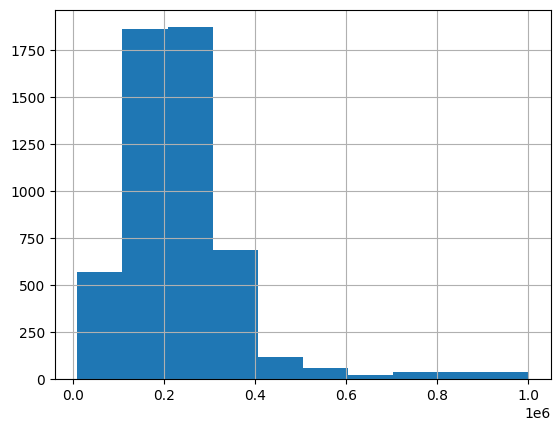

In [643]:
df.mileage.hist()

In [646]:
df[(df['mileage']>600000)]

,id,title,url,date_parsing,brend,volume,тип_двигателя,год,prise,dop_info,class_auto,body,state,door,fuel,transmission,conditioner,audio,mileage,contact,fone,date_notice,manth,model,len_dop_info
73,auto1691318,Volkswagen Vento,http://klaksona.net/avtorynok-pmr/auto1691318.html,2024-10-01,Volkswagen,1600.00,Бензин-Газ,1993.00,1000.00,NaN,No_info,No_info,No_info,No_info,No_info,No_info,No_info,автомагнитола,800000.00,Борис,77868613,2024-10-01 10:54:00,2024-10,Vento,3.00
137,auto1691244,Lexus RX 450h,http://klaksona.net/avtorynok-pmr/auto1691244.html,2024-10-01,Lexus,3500.00,Гибрид,2014.00,20500.00,"Лексус RX450h гибрид, 2014год, 3.5 бензин. Авто в идеальном состоянии все в оригинале. Комплектация: навигация, Bluetooth, HandsFree, камера заднего вида, круиз контроль, климат контроль, датчик дождя/датчик света, адаптивный ксенон с функцией AFS, электрический привод руля, сидений, багажника, память сидений, подогрев/обдув передних сидений, люк, система курсовой устойчивости. Состояние безупречное, оригинальный пробег 70т миль, новая резина. Абсолютно никаких вложений. Возможен обмен на авто с вашей доплатой.",Легковой,кроссовер,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),700000.00,LexusRX450h(Всеобъявленияэтогопользователя),077723326,2024-10-01 08:53:00,2024-10,RX 450h,520.00
164,auto1691217,Lexus RX 450h,http://klaksona.net/avtorynok-pmr/auto1691217.html,2024-10-01,Lexus,3500.00,Гибрид,2010.00,NaN,NaN,Легковой,внедорожник,Хорошее,4/5,бензин,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),890000.00,Иван(Всеобъявленияэтогопользователя),77899222,2024-09-30 23:37:00,2024-09,RX 450h,3.00
173,auto1686767,Infiniti QX60,http://klaksona.net/avtorynok-pmr/auto1686767.html,2024-10-01,Infiniti,3500.00,Бензин,2018.00,NaN,"Infinity QX60 рестайлингОригинальный пробег 73000 мильБольшой и очень комфортный автомобиль7 мест, практичный кожаный салонЭлектропривод крышки багажникаДатчики слепых зонАктивный круиз контрольОбогрев руля и сиденийПолный приводНовая резинаЗаменено масло в двигателе и АКППкамеры кругового обзора 360",Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),730000.00,077771215(Всеобъявленияэтогопользователя),077771215,2024-09-30 21:00:00,2024-09,QX60,301.00
188,auto1691185,Volvo XC90,http://klaksona.net/avtorynok-pmr/auto1691185.html,2024-10-01,Volvo,2000.00,Бензин,2016.00,29415.00,"Состояние отличное, вложений не требует Обслуженный автомобиль. 7 мест",Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитолаHi-End,820000.00,Я(Всеобъявленияэтогопользователя),77961088,2024-09-30 19:50:00,2024-09,XC90,70.00
189,auto1691182,Toyota Highlander,http://klaksona.net/avtorynok-pmr/auto1691182.html,2024-10-01,Toyota,2500.00,Гибрид,2022.00,47175.00,"Свежепригнанная. Состояние идеальное, полностью обслуженная. 7 мест, комплектация XLE.",Легковой,внедорожник,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитолаHi-End,820000.00,Я(Всеобъявленияэтогопользователя),77961088,2024-09-30 19:46:00,2024-09,Highlander,86.00
194,auto1686774,Nissan Rogue,http://klaksona.net/avtorynok-pmr/auto1686774.html,2024-10-01,Nissan,2500.00,Бензин,2017.00,NaN,2016г рестайлингПанорамная крышаАктивный круиз контрольДатчики слепых зонЭлектропривод крышки багажникаКруговой обзор 360 градусовПамять сиденьяОбогрев сидений и руляПолный привод 4*4Новая резинаАвтозапускLed оптика+ дневные ходовые огниПрактичный черный кожаный салон,Легковой,кроссовер,Отличное,4/5,бензин,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBиBluetooth),810000.00,077771215(Всеобъявленияэтогопользователя),077771215,2024-09-30 19:00:00,2024-09,Rogue,268.00
205,auto1691162,Honda CR-V,http://klaksona.net/avtorynok-pmr/auto1691162.html,2024-10-01,Honda,1498.00,Бензин,2020.00,27750.00,"Продам НОВУЮ Hondа CR-V. Пробег 943 км, слепые зоны, панорама, полный привод , колеса R18, автозапуск. Все месенджеры.",Легковой,внедорожник,Новый,4/5,бензин,автомат,климатконтроль,автомагнитолаCD/MP3(сUSBи

In [636]:
df['mileage'].describe()

count         5353.00000
mean       2101781.09808
std       60281031.17465
min          10000.00000
25%         150000.00000
50%         220000.00000
75%         298000.00000
max     2147483647.00000
Name: mileage, dtype: float64

## Преобразование признака contact

In [650]:
df.contact.unique()

array(['Тирасполь', 'Сергей', 'Игорь', 'Igor', 'Кристина',
       'МиихаилТатьяна', 'Andrei', 'Михаил', 'Александр', 'Iulia',
       'BMWE60', '07797299', '111', 'Вадим', 'Фольц', 'Валерий', 'Юрий',
       '77788606', 'Кирилл', '4500$', 'Е', '2200$', 'Анатолий', 'Mihail',
       'Dmitri', 'Пассатб4', 'Amg211', '068665108', 'Олег', 'Юра', 'Мерс',
       'AudiA6', 'Алексей', 'Nicolai', 'С', '077', 'СЕРГЕЙ',
       '+37378707131', 'Ден', 'эз', '077766777', '77524250', 'Camry',
       'Борис', 'Наталья', 'DmitriGulic', 'TOURAN', '060757282',
       'Николай', '...........', '37377545875', 'Gg', 'Natan', 'Метан',
       'Частное', '77842862', '77961555', 'Рено', 'VWLT-35', 'Андрей',
       'Миша', '55245593', 'BMWX5', 'LexusRX450h', 'ToyotaCamry', 'Приус',
       'AudiA8', '077932064', 'FordFusion', 'Иван', 'HONDA', '777',
       'Мерседес', 'АУРИС', 'БМВ', 'Артём', 'Регина', 'В', 'Евгений',
       '***', '077771215', 'KR', 'Виктор', '+37377870390', 'Степан',
       'Юлия', 'Ххххх', 'Дмитри

In [649]:
df['contact'] = df['contact'].apply(lambda x: str(x).replace('(Всеобъявленияэтогопользователя)',''))

## Преобразование признака fone

In [652]:
df.fone.unique()

array(['77904221', '77768794', '77777139', '77954052', '77827520',
       '77561456', '77537555', '77737980', '77995156', '77889073',
       '77997299', '77742629', '77768508', '77763060', '77817457',
       '77576667', '77788606', '77511835', '77984700', '77749422',
       '77845607', '77748140', '77599793', '69545952', '77964041',
       '77774796', '77794888', '77753132', '77857830', '68371529',
       '77879756', '77974330', '77794317', '77955303', '77716141',
       '77784190', '77591790', '77796668', '77521517', '78707131',
       '77511713', '77715295', '77524250', '77766777', '77966677',
       '77868613', '77716402', '77742794', '77775105', '77789231',
       '77736044', '77950635', '77719328', '77545875', '77903790',
       '77751188', '77555775', '77822144', '77870818', '77829539',
       '77842862', '77961555', '77779675', '77781988', '77751010',
       '77729181', '77847018', '77723326', '77711173', '77932064',
       '77942581', '77842748', '77760822', '77722885', '777581

In [651]:
df['fone'] = df['fone'].apply(lambda x: str(x).replace('+','').replace('-','')
                              .replace('(','').replace(')','')[-8:])

In [653]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7072 entries, 0 to 8167
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             7027 non-null   object        
 1   title          7027 non-null   object        
 2   url            7027 non-null   object        
 3   date_parsing   7027 non-null   datetime64[ns]
 4   brend          7027 non-null   object        
 5   volume         6151 non-null   float64       
 6   тип_двигателя  6445 non-null   object        
 7   год            7027 non-null   float64       
 8   prise          5527 non-null   float64       
 9   dop_info       6179 non-null   object        
 10  class_auto     7027 non-null   object        
 11  body           7027 non-null   object        
 12  state          7027 non-null   object        
 13  door           7027 non-null   object        
 14  fuel           7027 non-null   object        
 15  transmission   7027 non-nu

In [683]:
t = df.groupby(['manth', 'body']).id.count().reset_index()
t

,manth,body,id
0,2022-11,No_info,9
1,2022-11,автобус,1
2,2022-11,внедорожник,9
3,2022-11,грузовой,1
4,2022-11,кабриолет,1
5,2022-11,кроссовер,1
6,2022-11,купе,2
7,2022-11,лимузин,1
8,2022-11,микроавтобус,1
9,2022-11,минивен,13


<Axes: xlabel='manth', ylabel='id'>

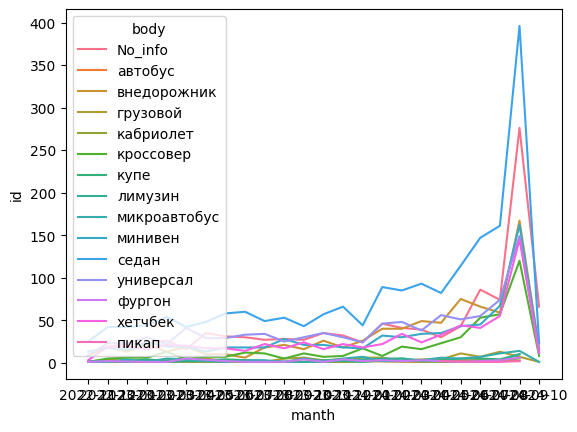

In [684]:
sns.lineplot(data=t, x=t["manth"].astype(str), y="id", hue='body')